# Workshop_1_Analysis
- Este jupyter trata todo el trabaho de carga y conexion a la base de datos, ademas de la clonacion del dataframe original con el nuevo campo solicidato Hired
- Ademas de todo ese proceso tambien se hace un breve analisis para poder asi estar mas familiarizado con el dataset que se esta trabajando en este primer workshop

# Importacion de bibliotecas
- Es importante recalcar que se estan manejando variables de entorno como buena practica y estas variabes se guardan en un archivo .env en el gitignore


In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import pymysql


# Carga y manejo de las variables de entorno
- Usamos variables de entorno con un archivo .env como buena practica en el tratamiento de las credenciales en el archivo main que hace todo el proceso (como es el caso de este notebook)

In [2]:
load_dotenv()


True

In [3]:
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_database = os.getenv("DB_DATABASE")


# Lectura del csv y exploracion general
### Este analisis general el cual nos devuelve la informacion de cada campo y alguno de los registros de nuestra tabla, nos permite poder identificar caracteristicas fundamentales a nuestro futuro analisis y proceso
- De este pequeño primer acercamiento podemos percartarnos de cosas como que el campo del dia de aplicacion de la candidaturia, es un objeto, formato que nos dificulta la forma de poder visualizar, analizar y graficar a mas a profundidad todo el material que nos ofrece una fecha completa (Año,mes,dia) 

In [4]:
import pandas as pd

candidates = 'C://Users//fedeg//OneDrive//Escritorio//Workshop_ETL1//Data//candidates.csv' 
candidates_df = pd.read_csv(candidates, delimiter=';') 
print(candidates_df.head())
print(candidates_df.info())


   First Name   Last Name                      Email Application Date  \
0  Bernadette   Langworth        leonard91@yahoo.com       2021-02-26   
1      Camryn    Reynolds        zelda56@hotmail.com       2021-09-09   
2       Larue      Spinka   okey_schultz41@gmail.com       2020-04-14   
3        Arch      Spinka     elvera_kulas@yahoo.com       2020-10-01   
4       Larue  Altenwerth  minnie.gislason@gmail.com       2020-05-20   

   Country  YOE  Seniority                         Technology  \
0   Norway    2     Intern                      Data Engineer   
1   Panama   10     Intern                      Data Engineer   
2  Belarus    4  Mid-Level                     Client Success   
3  Eritrea   25    Trainee                          QA Manual   
4  Myanmar   13  Mid-Level  Social Media Community Management   

   Code Challenge Score  Technical Interview Score  
0                     3                          3  
1                     2                         10  
2          

# Conexion con la base de datos mysql

In [5]:
mysql_connection = pymysql.connect(db=db_database, user=db_user, passwd=db_password)


# Carga de los datos y la tabla candidates a la base de datos
### Posteriormente de la lectura y la creacion de la conexion con nuestra base de datos procedemos a cargar los datos de nuestra tabla a la base de datos


In [6]:
try:
    mysql_connection_str = f'mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_database}'
    mysql_db_connection = create_engine(mysql_connection_str)

   
    candidates_df.to_sql('candidates', con=mysql_db_connection, index=False, if_exists='replace')
    print("Datos cargados correctamente en la tabla 'candidates'.")

except pymysql.Error as e:
   
    print(f"Error al conectar a la base de datos MySQL: {e}")

finally:
   
    if 'mysql_db_connection' in locals():
        mysql_db_connection.dispose()


Datos cargados correctamente en la tabla 'candidates'.


# Se crea un nuevo dataframe el cual es una copia de la tabla original con un nuevo campo de hired 

- A lo largo del codigo tambien se analiza la cantidad de registros individuales que cumplen con cada restriccion, como la solicitud a la base de datos del total de tablas para poder confirmar la creacion de esta ultima
- Si el campo de code_challeng y tecnical_interview tienen un valor mayor o igual a 7 en su registro este se considerara como un registro aprobado teniendo un Yes en el campo hired
- Si por el contrario el registro no cumple con uno o con ninguno de esos requerimientos en esos dos diferentes campos este no se considerara aprobado y tendra un No en el campo hired

In [7]:
sql_query = "SELECT * FROM candidates"
candidates_df = pd.read_sql_query(sql_query, mysql_db_connection)

candidates_df['Hired'] = candidates_df.apply(lambda row: 'Yes' if row['Technical Interview Score'] >= 7 and row['Code Challenge Score'] >= 7 else 'No', axis=1)

code_challenge_aprobados_df = candidates_df[candidates_df['Code Challenge Score'] >= 7] 
print(f"Cantidad de registros con Code Challenge Score >= 7: {len(code_challenge_aprobados_df)}")

technical_interview_aprobados_df = candidates_df[candidates_df['Technical Interview Score'] >= 7] 
print(f"Cantidad de registros con Technical Interview Score >= 7: {len(technical_interview_aprobados_df)}")

sql_query_tables = "SHOW TABLES;"
tabla_df = pd.read_sql_query(sql_query_tables, mysql_db_connection)
print("Lista de tablas en la base de datos:")
print(tabla_df)

candidates_hired = 'candidates_hired'
candidates_df.to_sql(candidates_hired, mysql_db_connection, index=False, if_exists='replace')

print(f"Datos cargados correctamente en la tabla '{candidates_hired}'.")

sql_query_hired = f"SELECT * FROM {candidates_hired}"
candidates_hired_df = pd.read_sql_query(sql_query_hired, mysql_db_connection)
print("Nuevo DataFrame con el campo 'Hired'")

mysql_db_connection.dispose()


Cantidad de registros con Code Challenge Score >= 7: 18232
Cantidad de registros con Technical Interview Score >= 7: 18269
Lista de tablas en la base de datos:
  Tables_in_workshop_1
0           candidates
1     candidates_hired
Datos cargados correctamente en la tabla 'candidates_hired'.
Nuevo DataFrame con el campo 'Hired'


# Confirmamos que el nuevo dataset cumple con el nuevo campo y con sus restricciones

In [8]:
print(candidates_hired_df.head())

   First Name   Last Name                      Email Application Date  \
0  Bernadette   Langworth        leonard91@yahoo.com       2021-02-26   
1      Camryn    Reynolds        zelda56@hotmail.com       2021-09-09   
2       Larue      Spinka   okey_schultz41@gmail.com       2020-04-14   
3        Arch      Spinka     elvera_kulas@yahoo.com       2020-10-01   
4       Larue  Altenwerth  minnie.gislason@gmail.com       2020-05-20   

   Country  YOE  Seniority                         Technology  \
0   Norway    2     Intern                      Data Engineer   
1   Panama   10     Intern                      Data Engineer   
2  Belarus    4  Mid-Level                     Client Success   
3  Eritrea   25    Trainee                          QA Manual   
4  Myanmar   13  Mid-Level  Social Media Community Management   

   Code Challenge Score  Technical Interview Score Hired  
0                     3                          3    No  
1                     2                         10  

# Cantidad de registros que no cumplen las restricciones en el nuevo campo
- Esto lo hacemos para dar un paso a paso de lo que sera una analisis sobre estos registros apropados y no aprobados

In [9]:
Total_no_hired_registers = candidates_hired_df[candidates_hired_df['Hired'] == 'No'].shape[0]
print(f"Total de registros que no cumplen los requerimientos para la contratacion: {Total_no_hired_registers}")

Total de registros que no cumplen los requerimientos para la contratacion: 43302


# Cantidad de registros que cumplen con las restricciones del nuevo campo

In [10]:
Total_yes_hired_registers = candidates_hired_df[candidates_hired_df['Hired'] == 'Yes'].shape[0]
print(f"Total de registros que cumplen con los requerimientos para la contratacion: {Total_yes_hired_registers}")

Total de registros que cumplen con los requerimientos para la contratacion: 6698


# Visualizacion de registros por campo hired
- Con esta grafica nos podemos dar una idea de la diferencia entre las candidaturias que fueron aprobadas y las que no en nuestro dataset

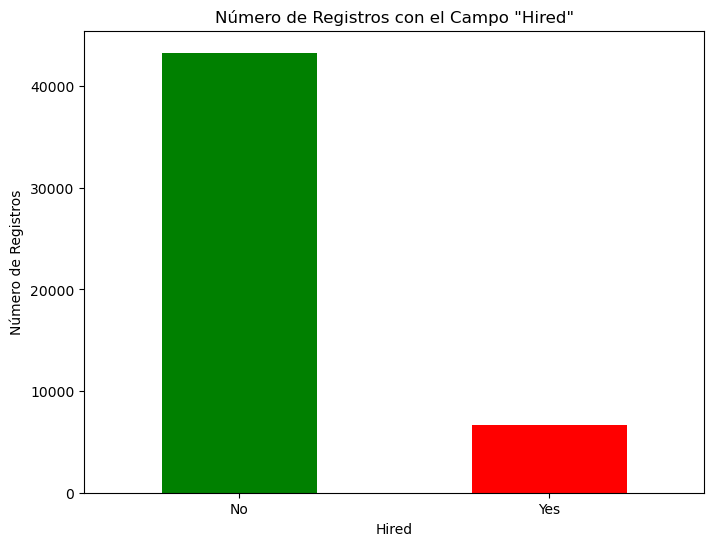

In [11]:
Total_Hired = candidates_hired_df['Hired'].value_counts()

plt.figure(figsize=(8, 6))
Total_Hired.plot(kind='bar', color=['green', 'red'])
plt.title('Número de Registros con el Campo "Hired"')
plt.xlabel('Hired')
plt.ylabel('Número de Registros')
plt.xticks(rotation=0)
plt.show()


# Analisis del porcentaje de contratados que hubo segun el nuevo dataframe
- Es intersante ver de cuantos registros totales que solo el 13.40% de todos esos registros fueron los que cumplieron los requerimientos para ser contratados

In [12]:
Registers_Hired = len(candidates_hired_df[candidates_hired_df['Hired'] == 'Yes'])

Total_of_registers = len(candidates_hired_df)

Rate_of_registers = (Registers_Hired  / Total_of_registers) * 100

print(f"Porcentaje de contratados: {Rate_of_registers:.2f}%")


Porcentaje de contratados: 13.40%


# Grafico de pastel

- Este grafico lo hacemos con un proposito y es poder visualizar la totalidad de candidaturias que no fueron aprobadas, contra las que ahora sabemos son las otras 13.40% candidaturias que sabemos que si fueron aprobadas

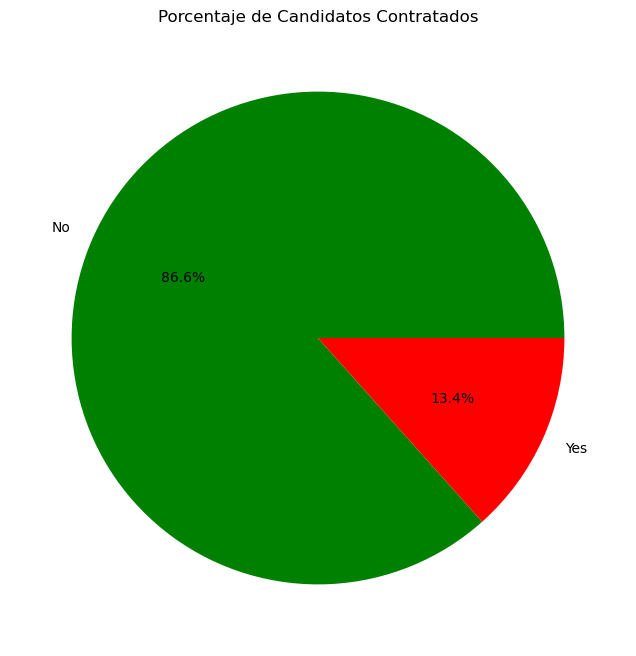

In [13]:
Number_of_hireds = candidates_hired_df['Hired'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(Number_of_hireds, labels=Number_of_hireds.index, autopct='%1.1f%%', colors=['green', 'red'])

plt.title('Porcentaje de Candidatos Contratados')

plt.show()


# Grafico de barras del numero de aprobados por su tecnologia
- Este grafico nos pertime ver una tendendecia entre dos tecnologias llamadas "Game development" y "Dep Ops" las cuales son las mas aceptadas en nuestro dataset, mientras que las otras siguen un numero de registros no tan grande entre si

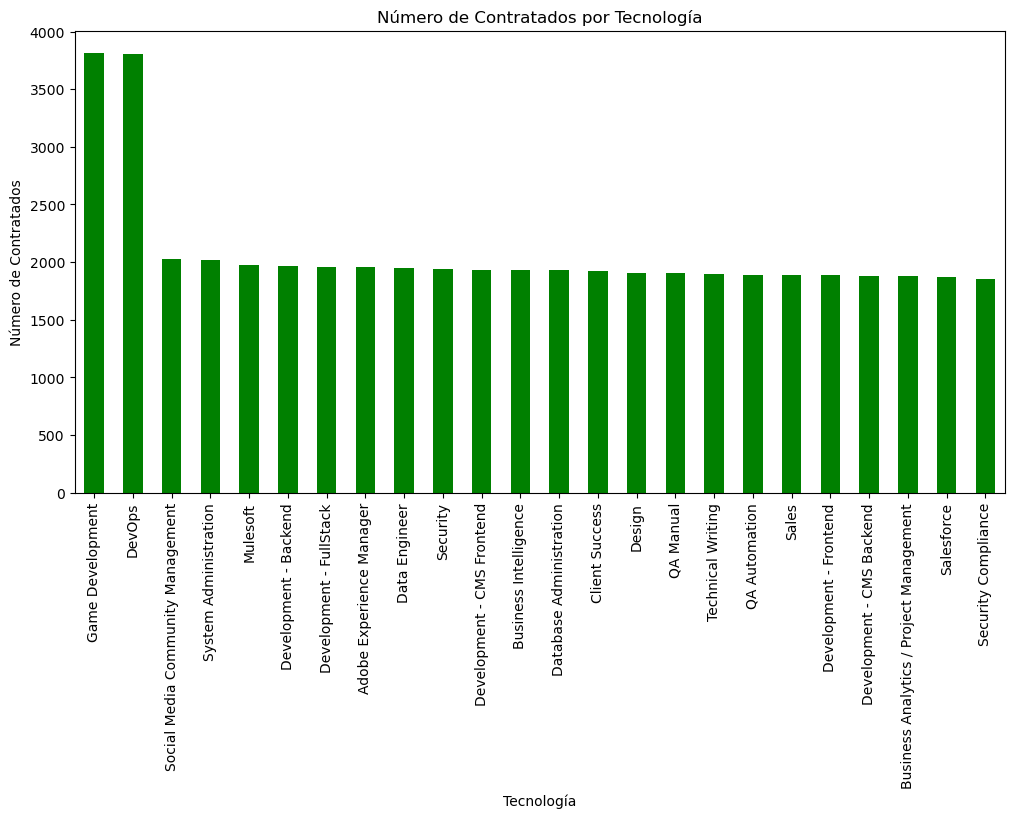

In [14]:
Hired_by_tecnology = candidates_hired_df.groupby('Technology')['Hired'].count().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
Hired_by_tecnology.plot(kind='bar', color='green')
plt.title('Número de Contratados por Tecnología')
plt.xlabel('Tecnología')
plt.ylabel('Número de Contratados')
plt.show()